# Mini-Challenge 2

Modul: Deep Learning  
Thema: Paper-Studium und Umsetzung  
Student: Si Ben Tran   
Fachexperte: Martin Melchior  
Abgabetermin: Ende FS23   

Ziel:  
Vertiefung in ein eher aktuelles Paper aus der Forschung und Umsetzung eines darin beschriebenen oder verwandten Tasks - gemäss Vereinbarung mit dem Fachcoach. 

Beispiel:  
Implementiere, trainiere und validiere ein Deep Learning Modell für Image Captioning wie beschrieben im Paper Show and Tell.

Zeitlicher Rahmen:  
Wird beim Schritt 1 verbindlich festgelegt.

Beurteilung:  
Beurteilt wird auf Basis des abgegebenen Notebooks:  
•	Vollständige und korrekte Umsetzung der vereinbarten Aufgabestellung.  
•	Klare, gut-strukturierte Umsetzung.   
•	Schlüssige Beschreibung und Interpretation der Ergebnisse. Gut gewählte und gut kommentierten Plots und Tabellen.  
•	Vernünftiger Umgang mit (Computing-)Ressourcen.  
•	Verständliche Präsentation der Ergebnisse.  

Referenzen, Key Words  
•	Word Embedding (z.B. word2vec, glove), um Wörter in numerische Vektoren in einem geeignet dimensionierten Raum zu mappen. Siehe z.B. Andrew Ng, Coursera: [Link](https://www.coursera.org/lecture/nlp-sequence-models/learning-word-embeddings-APM5s)      
•	Bild Embedding mittels vortrainierten (evt. retrained) Netzwerken wie beispielsweise ResNet, GoogLeNet, EfficientNet oder ähnlich Transfer-Learning.  
•	Seq2Seq Models bekannt für Sprach-Übersetzung. 

Daten:   
•	Gemäss Vereinbarung (für Captioning: [Flickr8k-Daten](https://www.kaggle.com/adityajn105/flickr8k/activity)).

•	Absprache/Beschluss mit Coach und Beschluss, was evaluiert werden soll.
 

# Arbeitsschritte

In [21]:
# Torch Pakete
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

## Schritt 1: Daten
Wir erkennen bei der Spalte *image*, das ein jpg. Bilddatei mehrere *catpion* hat.


In [22]:
image_path = 'flickr8k/Images'
data = pd.read_csv("flickr8k/captions.txt")
image_unique = data['image'].unique()
display(data)

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


## Visualisierung

Bei der Visualisierung der Bilder erkenne wir:
- Personen oder Tiere
- Unterschiedliche Grössen
- Unterschiedliche Auflösung

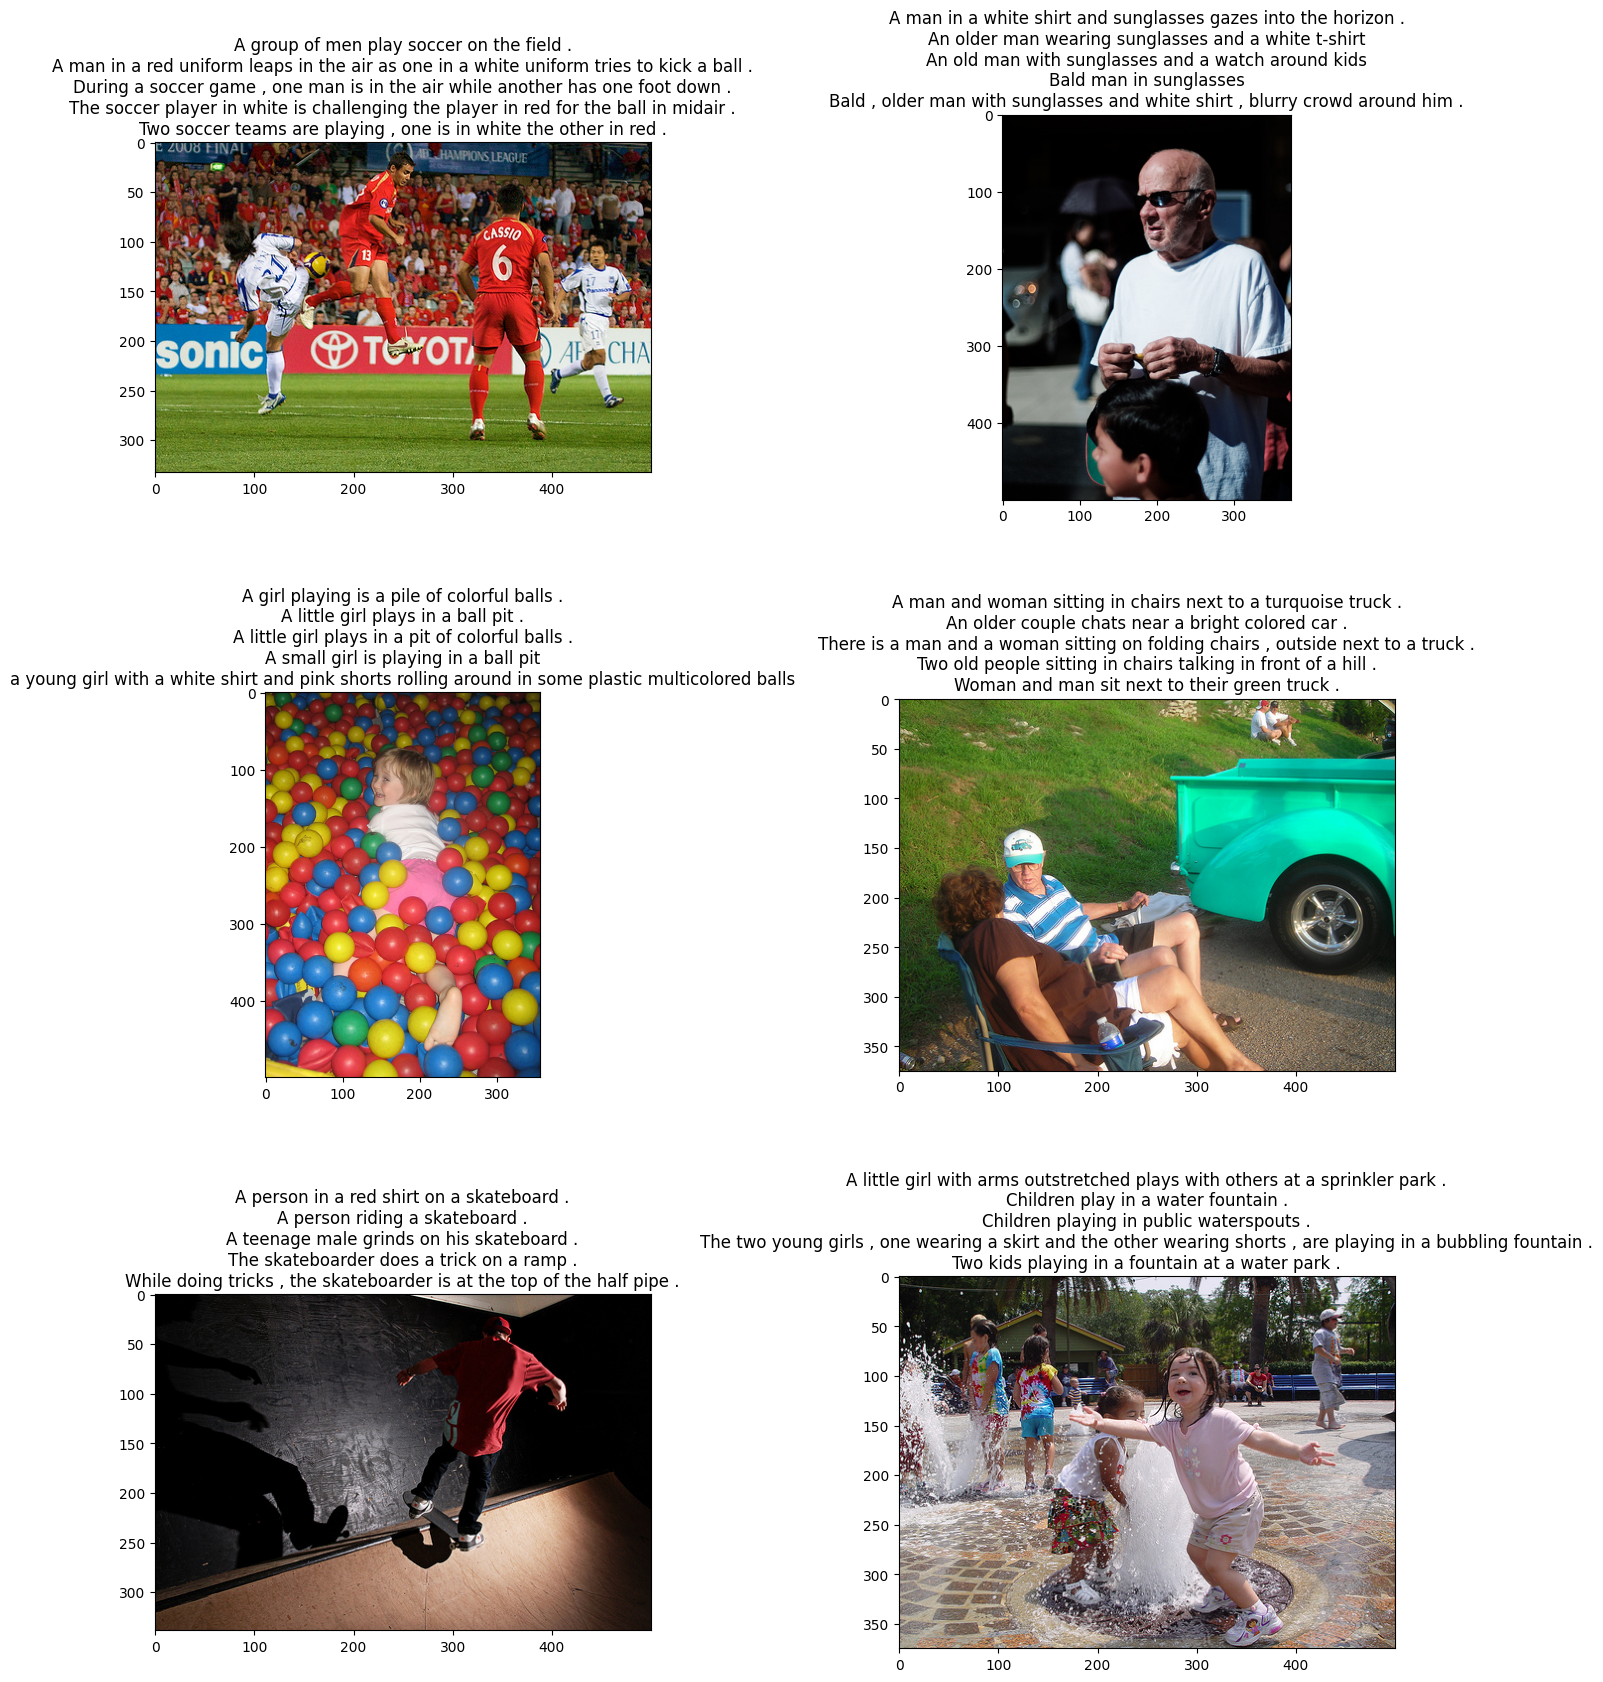

In [23]:
def read_image(image_id):
    """
    This function reads an image from a specific path and returns the image object.
    """
    image = Image.open(image_path + "/" + image_id)
    return image

def get_captions(image_id):
    """
    This function retrieves the captions associated with an image ID from the data dictionary.
    """
    captions = []
    for i in range(len(data)):
        if data['image'][i] == image_id:
            captions.append(data['caption'][i])
    captions = '\n'.join(captions)
    return captions

def plot_n_m_image_caption(n,m):
    """
    This function plots a grid of n x m images along with their captions.
    """
    fig, ax = plt.subplots(n,m,figsize=(16,20))
    for i in range(n):
        for j in range(m):
            index = np.random.randint(0,len(image_unique))
            image_id = image_unique[index]
            image = read_image(image_id)
            captions = get_captions(image_id)
            ax[i,j].imshow(np.asarray(image))
            ax[i,j].set_title(captions)
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.show()

# plot n x m images and its captions
plot_n_m_image_caption(3,2)

## Preprocessing der Biler

- ToPILImage
- CenterCrop
- Resize 
- ToTensor
- Normalize

In [24]:
from torchvision.transforms import Compose, CenterCrop, Resize, ToTensor, ToPILImage, Normalize

# Transformations for the image
image_transformations = Compose([
    ToPILImage(),
    CenterCrop((500, 500)),
    Resize((224,224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229,0.224,0.225])
])


## PreProcessing Captions

In [25]:
def process_captions(data):
    data['caption'] = data['caption'].apply(lambda x: '<start> ' + x + ' <end>')
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace('[^A-Za-z]', ''))
    return data['caption']

data['process_caption'] = process_captions(data)
display(data)

,image,caption,process_caption
0,1000268201_693b08cb0e.jpg,<start> a child in a pink dress is climbing up...,<start> a child in a pink dress is climbing up...
1,1000268201_693b08cb0e.jpg,<start> a girl going into a wooden building . ...,<start> a girl going into a wooden building . ...
2,1000268201_693b08cb0e.jpg,<start> a little girl climbing into a wooden p...,<start> a little girl climbing into a wooden p...
3,1000268201_693b08cb0e.jpg,<start> a little girl climbing the stairs to h...,<start> a little girl climbing the stairs to h...
4,1000268201_693b08cb0e.jpg,<start> a little girl in a pink dress going in...,<start> a little girl in a pink dress going in...
...,...,...,...
40450,997722733_0cb5439472.jpg,<start> a man in a pink shirt climbs a rock fa...,<start> a man in a pink shirt climbs a rock fa...
40451,997722733_0cb5439472.jpg,<start> a man is rock climbing high in the air...,<start> a man is rock climbing high in the air...
40452,997722733_0cb5439472.jpg,<start> a person in a red shirt climbing up a ...,<start> a person in a red shirt climbing up a ...
40453,997722733_0cb5439472.jpg,<start> a rock climber in a red shirt . <end>,<start> a rock climber in a red shirt . <end>


In [26]:
from torchtext.data import get_tokenizer

# Tokenize captions
tokenizer = get_tokenizer('basic_english')
data['tokens'] = data['process_caption'].apply(tokenizer)
display(data)



,image,caption,process_caption,tokens
0,1000268201_693b08cb0e.jpg,<start> a child in a pink dress is climbing up...,<start> a child in a pink dress is climbing up...,"[<start>, a, child, in, a, pink, dress, is, cl..."
1,1000268201_693b08cb0e.jpg,<start> a girl going into a wooden building . ...,<start> a girl going into a wooden building . ...,"[<start>, a, girl, going, into, a, wooden, bui..."
2,1000268201_693b08cb0e.jpg,<start> a little girl climbing into a wooden p...,<start> a little girl climbing into a wooden p...,"[<start>, a, little, girl, climbing, into, a, ..."
3,1000268201_693b08cb0e.jpg,<start> a little girl climbing the stairs to h...,<start> a little girl climbing the stairs to h...,"[<start>, a, little, girl, climbing, the, stai..."
4,1000268201_693b08cb0e.jpg,<start> a little girl in a pink dress going in...,<start> a little girl in a pink dress going in...,"[<start>, a, little, girl, in, a, pink, dress,..."
...,...,...,...,...
40450,997722733_0cb5439472.jpg,<start> a man in a pink shirt climbs a rock fa...,<start> a man in a pink shirt climbs a rock fa...,"[<start>, a, man, in, a, pink, shirt, climbs, ..."
40451,997722733_0cb5439472.jpg,<start> a man is rock climbing high in the air...,<start> a man is rock climbing high in the air...,"[<start>, a, man, is, rock, climbing, high, in..."
40452,997722733_0cb5439472.jpg,<start> a person in a red shirt climbing up a ...,<start> a person in a red shirt climbing up a ...,"[<start>, a, person, in, a, red, shirt, climbi..."
40453,997722733_0cb5439472.jpg,<start> a rock climber in a red shirt . <end>,<start> a rock climber in a red shirt . <end>,"[<start>, a, rock, climber, in, a, red, shirt,..."


In [27]:
from gensim.models import Word2Vec

data['token_embedding'] = data['tokens'].apply(lambda x: Word2Vec([x], min_count=1))

display(data)

,image,caption,process_caption,tokens,token_embedding
0,1000268201_693b08cb0e.jpg,<start> a child in a pink dress is climbing up...,<start> a child in a pink dress is climbing up...,"[<start>, a, child, in, a, pink, dress, is, cl...","Word2Vec<vocab=17, vector_size=100, alpha=0.025>"
1,1000268201_693b08cb0e.jpg,<start> a girl going into a wooden building . ...,<start> a girl going into a wooden building . ...,"[<start>, a, girl, going, into, a, wooden, bui...","Word2Vec<vocab=9, vector_size=100, alpha=0.025>"
2,1000268201_693b08cb0e.jpg,<start> a little girl climbing into a wooden p...,<start> a little girl climbing into a wooden p...,"[<start>, a, little, girl, climbing, into, a, ...","Word2Vec<vocab=10, vector_size=100, alpha=0.025>"
3,1000268201_693b08cb0e.jpg,<start> a little girl climbing the stairs to h...,<start> a little girl climbing the stairs to h...,"[<start>, a, little, girl, climbing, the, stai...","Word2Vec<vocab=12, vector_size=100, alpha=0.025>"
4,1000268201_693b08cb0e.jpg,<start> a little girl in a pink dress going in...,<start> a little girl in a pink dress going in...,"[<start>, a, little, girl, in, a, pink, dress,...","Word2Vec<vocab=13, vector_size=100, alpha=0.025>"
...,...,...,...,...,...
40450,997722733_0cb5439472.jpg,<start> a man in a pink shirt climbs a rock fa...,<start> a man in a pink shirt climbs a rock fa...,"[<start>, a, man, in, a, pink, shirt, climbs, ...","Word2Vec<vocab=10, vector_size=100, alpha=0.025>"
40451,997722733_0cb5439472.jpg,<start> a man is rock climbing high in the air...,<start> a man is rock climbing high in the air...,"[<start>, a, man, is, rock, climbing, high, in...","Word2Vec<vocab=12, vector_size=100, alpha=0.025>"
40452,997722733_0cb5439472.jpg,<start> a person in a red shirt climbing up a ...,<start> a person in a red shirt climbing up a ...,"[<start>, a, person, in, a, red, shirt, climbi...","Word2Vec<vocab=15, vector_size=100, alpha=0.025>"
40453,997722733_0cb5439472.jpg,<start> a rock climber in a red shirt . <end>,<start> a rock climber in a red shirt . <end>,"[<start>, a, rock, climber, in, a, red, shirt,...","Word2Vec<vocab=9, vector_size=100, alpha=0.025>"


---

In [34]:
data['token_embedding'][0]

## Schritt 2: Aufbau Modellierung

Überlege Dir, welche Modell-Architektur Sinn machen könnte. Das Paper von Vinyals (https://arxiv.org/pdf/1411.4555.pdf) war wichtig in diesem Zusammenhang. du kannst Dich auf Ihre Architektur beziehen oder auch eine eigene, evt. einfachere verwenden. 
Zwei Modell-Varianten sollen aufgebaut werden:

Absprache/Beschluss mit Coach und Beschluss, was evaluiert werden soll.


In [4]:
# CODE

---

## Schritt 3: Training und Evaluation

Trainiere und evaluiere das Modell. Beschreibe genau was Du tust und warum Du es tust.

In [5]:
# CODE

---

## Schritt 4: Präsentation / Bericht

Präsentation (~10m): Kurze Präsentation mit Diskussion der wichtigsten Ergebnisse. 
Q&A (~10min): Klärung von Verständnisfragen zum Paper und der Umsetzung.

Bericht in Form eines gut dokumentierten, übersichtlichen Jupyter Notebooks.
Dieses soll schliesslich auch abgegeben werden und dem Fachexperten erlauben, die Schritte nachzuvollziehen (allenfalls auch das Training erneut laufen zu lassen).


---